# Задача 1

Модифицируйте логирование, чтобы выводились не пошаговые значения потерь, а средние значения за эпоху.

In [ ]:
import os

# Указываем путь, куда хотим всё сохранить
save_path = 'data/open-images-bus-trucks'

# Создаем директорию, если она не существует
os.makedirs(save_path, exist_ok=True)

# Переходим в директорию для скачивания
os.chdir(save_path)

# Проверка на существование содержимого
if not os.path.exists('open-images-bus-trucks'):
    # Установка зависимостей
    !pip install -q torch_snippets==0.5
    # Скачивание архива
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    # Распаковка
    !tar -xf open-images-bus-trucks.tar.xz
    # Удаление архива
    !rm open-images-bus-trucks.tar.xz
    # Клонирование репозитория
    !git clone https://github.com/sizhky/ssd-utils/

Клонирование в «ssd-utils»...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Получение объектов: 100% (9/9), 13.65 КиБ | 102.00 КиБ/с, готово.


In [8]:
%cd ssd-utils

/home/danya/Рабочий стол/Финашка/Машинное зрение/data/open-images-bus-trucks/ssd-utils/data/open-images-bus-trucks/ssd-utils


In [38]:
import torch
import glob
from torch_snippets import *
from tqdm import tqdm

In [17]:
DATA_ROOT = '../open-images-bus-trucks/'
IMAGE_ROOT = f'{DATA_ROOT}/images'
DF_RAW = pd.read_csv(f'{DATA_ROOT}/df.csv')

df = DF_RAW.copy()
df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())] # избавляемся от неуникальных и NaN
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())} # каждому уникальному классу присваивается индекс начиная с 1
label2target['background'] = 0 # а фон это 0
target2label = {t:l for l,t in label2target.items()} # обратный словарь
background_class = label2target['background']
num_classes = len(label2target)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
import collections, os, torch
from PIL import Image
from torchvision import transforms
normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
# denormalize = transforms.Normalize(
#                 mean=[-0.485/0.229,-0.456/0.224,-0.406/0.255],
#                 std=[1/0.229, 1/0.224, 1/0.255]
#             )
denormalize = transforms.Normalize(
                mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225]
            )

def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()

class OpenDataset(torch.utils.data.Dataset): # класс для данных
    w, h = 300, 300
    def __init__(self, df, image_dir=IMAGE_ROOT): # принимаем df и директорию с изображениями
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*') # см пояснения нижу в ячейке
        self.df = df
        self.image_infos = df.ImageID.unique() # получаем уникальные id
        logger.info(f'{len(self)} items loaded') # просто вывод количества загруженных файлов

    def __getitem__(self, ix): # метод загружает и подготавливает один элемент данных (изображение с его аннотациями) по заданному индексу
        # Загрузка изображения
        image_id = self.image_infos[ix] # Получаем ID изображения по индексу в датасете
        img_path = find(image_id, self.files) # Находим полный путь к файлу изображения (см пояснения ниже)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        # data = df[df['ImageID'] == image_id]
        data = self.df[self.df['ImageID'] == image_id] # фильтруем df по текущему image_id
        labels = data['LabelName'].values.tolist() # извлекаем метки классов LabelName
        data = data[['XMin','YMin','XMax','YMax']].values # Извлекаем координаты bounding boxes из df
        data[:,[0,2]] *= self.w # координаты x умножаем на ширину (преобразуем в абсолютные координаты)
        data[:,[1,3]] *= self.h # координаты y умножаем на высоту (преобразуем в абсолютные координаты)
        boxes = data.astype(np.uint32).tolist() # в целые значения и в список
        return img, boxes, labels

    def collate_fn(self, batch): # метод обрабатывает батч данных, подготовленный __getitem__,
    # и преобразует его в формат, пригодный для передачи в нейросеть.
        images, boxes, labels = [], [], []
        for item in batch:
            img, image_boxes, image_labels = item # Распаковываем каждый элемент на изображение, боксы и метки
            img = preprocess_image(img)[None] # [None] добавляет размерность батча (превращает [H,W,C] в [1,H,W,C])
            images.append(img)
            boxes.append(torch.tensor(image_boxes).float().to(device)/300.) # делим на 300. чтоб было в [0,1]
            labels.append(torch.tensor([label2target[c] for c in image_labels]).long().to(device))
        images = torch.cat(images).to(device) # Объединяем все изображения в один тензор с размерностью [B,C,H,W]
        return images, boxes, labels # и возвращаем
    def __len__(self):
        return len(self.image_infos)

In [19]:
imgs_0 = glob.glob('../open-images-bus-trucks/images'+'/*') # вид ссылок на изображения
imgs_0[:3]

['../open-images-bus-trucks/images/fdabd5fb1191a697.jpg',
 '../open-images-bus-trucks/images/09feecbc4f018b2c.jpg',
 '../open-images-bus-trucks/images/88d95a24ea1aa1b7.jpg']

In [20]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import glob

trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99) # уникальные id изображений, делим на trn и val
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4,
                          collate_fn=train_ds.collate_fn,
                          drop_last=False)
test_loader = DataLoader(test_ds, batch_size=4,
                         collate_fn=test_ds.collate_fn,
                         drop_last=False)

[04/04/25 18:20:35] INFO     13702 items loaded                                           ]8;id=952072;file:///tmp/ipykernel_143303/3183796856.py\3183796856.py]8;;\:]8;id=380031;file:///tmp/ipykernel_143303/3183796856.py#__init__:29\__init__:29]8;;\

                    INFO     1523 items loaded                                            ]8;id=532269;file:///tmp/ipykernel_143303/3183796856.py\3183796856.py]8;;\:]8;id=712995;file:///tmp/ipykernel_143303/3183796856.py#__init__:29\__init__:29]8;;\

In [21]:
def train_batch(inputs, model, criterion, optimizer):
    model.train()
    N = len(train_loader)
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss
@torch.no_grad()
def validate_batch(inputs, model, criterion):
    model.eval()
    images, boxes, labels = inputs
    _regr, _clss = model(images)
    loss = criterion(_regr, _clss, boxes, labels)
    return loss

In [28]:
from model import SSD300, MultiBoxLoss
from detect import *

In [43]:
from torch_snippets import Report

n_epochs = 3
model = SSD300(num_classes, device) # принимает num_classes + фон
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy, device=device)

log = Report(n_epochs=n_epochs) # создает объект логирования и автоматически заносит туда метрики loss, accuracy и др.
logs_to_print = 3 # определяет как часто выводить логи в консоль

/home/danya/anaconda3/envs/new/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/danya/anaconda3/envs/new/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Loaded base model.



/home/danya/anaconda3/envs/new/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [44]:
len(train_loader), len(test_loader)

(3426, 381)

In [45]:
tl = next(iter(train_loader))
len(tl)

3

In [36]:
print(len(trn_df), len(val_df))

21598 2464


In [46]:
for epoch in range(3): 
    train_loss_sum = 0.0
    val_loss_sum = 0.0

    for inputs in tqdm(train_loader):
        loss = train_batch(inputs, model, criterion, optimizer)
        train_loss_sum += loss.item()
    
    avg_train_loss = train_loss_sum / len(train_loader)
    
    for inputs in test_loader:
        loss = validate_batch(inputs, model, criterion)
        val_loss_sum += loss.item()
    
    avg_val_loss = val_loss_sum / len(test_loader)
    
    log.record(epoch + 1, trn_loss=avg_train_loss, val_loss=avg_val_loss)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

100%|██████████| 3426/3426 [03:01<00:00, 18.87it/s]


EPOCH: 1.000	trn_loss: 3.514	val_loss: 2.877	(203.76s - 407.51s remaining)
Epoch 1: Train Loss = 3.5143, Val Loss = 2.8772


100%|██████████| 3426/3426 [03:01<00:00, 18.85it/s]


EPOCH: 2.000	trn_loss: 2.586	val_loss: 2.507	(394.06s - 197.03s remaining)
Epoch 2: Train Loss = 2.5856, Val Loss = 2.5066


100%|██████████| 3426/3426 [03:01<00:00, 18.86it/s]


EPOCH: 3.000	trn_loss: 2.187	val_loss: 2.308	(584.32s - 0.00s remaining)
Epoch 3: Train Loss = 2.1872, Val Loss = 2.3075


# Задача 2

Написать код, который отображает 5 случайных изображений из датасета с нарисованными bounding boxes и подписями классов.

Изображение 1:
Bounding Boxes: [[173, 6, 257, 51]]
Labels with confidence: ['Truck @ 0.87']


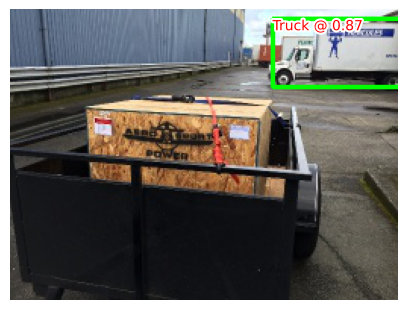

Изображение 2:
Bounding Boxes: [[2, 83, 91, 135]]
Labels with confidence: ['Truck @ 0.93']


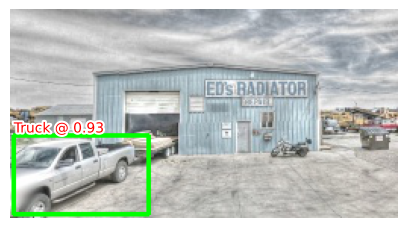

Изображение 3:
Bounding Boxes: [[20, 23, 233, 173]]
Labels with confidence: ['Truck @ 0.99']


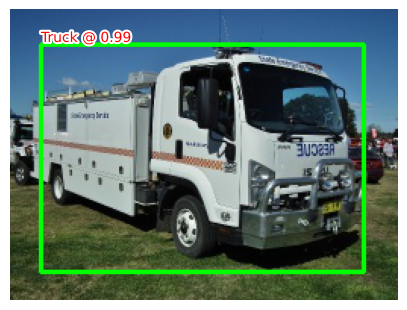

Изображение 4:
Bounding Boxes: [[16, 48, 244, 133]]
Labels with confidence: ['Bus @ 1.00']


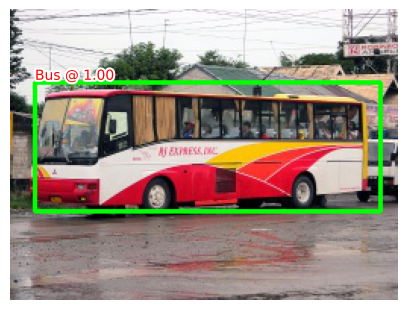

Изображение 5:
Bounding Boxes: [[-2, 9, 240, 183]]
Labels with confidence: ['Truck @ 0.96']


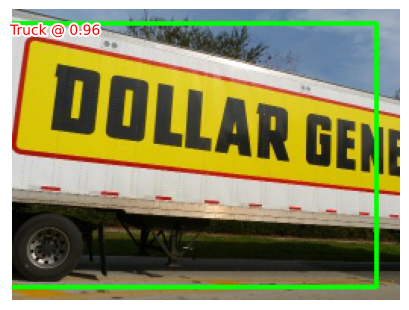

In [47]:
def display_random_detections(test_ds, model, device, target2label, n=5, 
                              min_score=0.5, max_overlap=0.5, top_k=200, text_sz=10):

    for i in range(n):
        image_id = choose(test_ds.image_infos)
        img_path = find(image_id, test_ds.files)
        original_image = Image.open(img_path, mode='r').convert('RGB')
        
        bbs, labels, scores = detect(original_image,
                                     model,
                                     min_score=min_score,
                                     max_overlap=max_overlap,
                                     top_k=top_k,
                                     device=device)
        
        labels = [target2label[c.item()] for c in labels]
        label_with_conf = [f'{l} @ {s:.2f}' for l, s in zip(labels, scores)]
        
        print(f"Изображение {i+1}:")
        print("Bounding Boxes:", bbs)
        print("Labels with confidence:", label_with_conf)
        
        show(original_image, bbs=bbs, texts=label_with_conf, text_sz=text_sz)

display_random_detections(test_ds, model, device, target2label, n=5)